### シフトに対する復元

In [4]:
import pickle
import os
import re
from itertools import combinations_with_replacement
import torch
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from shift_funcs import FUNCS_INVERT, ACTIONS_INVERT, FUNCS_DIAG
from matplotlib import pyplot as plt
import numpy as np

SEED = 0
SAMPLE_SIZE = 1000

In [5]:
# def augument_data(source):
#     data = []
#     for c in source:
#         new = [
#             c,
#             np.rot90(c, np.random.randint(1, 4)),
#             np.fliplr(c),
#             np.flipud(c)                
#         ]
#         data.extend(new)
#     data = np.array(data, dtype=source.dtype)
#     return data

In [5]:
def apply(Dx, indices, funcs):  
    Dy = []
    for k, i in enumerate(indices):
        x = Dx[k]
        y = funcs[i](x.copy())
        Dy.append(y)
    return np.array(Dy)

In [8]:
def create_dataset(TYPE, FUNCS):
    candy = list(range(len(FUNCS)))
    os.makedirs('data/%s' % TYPE, exist_ok=True)
    # train dataset
    mnist_train_dataset = datasets.MNIST(root='../open_data/', train=True, download=True)
    np.random.seed(0)
    idx = np.random.choice(mnist_train_dataset.data.shape[0], 1000)
    train_Dx = mnist_train_dataset.data[idx].numpy() / 255

    np.random.seed(1)
    train_func_indices = np.random.choice(candy, train_Dx.shape[0])
    train_Dy = apply(train_Dx, train_func_indices, FUNCS)
    np.savez(
        'data/%s/train_dataset.npz' % TYPE,
        train_dataset=train_Dy,
        original_dataset=train_Dx,
        train_func_labels=train_func_indices,
    )

    ### test dataset
    mnist_test_dataset = datasets.MNIST(root='../open_data/', train=False, download=True)
    test_Dx = mnist_test_dataset.data.numpy() / 255
    np.random.seed(3)
    test_func_indices = np.random.choice(candy, test_Dx.shape[0])

    test_Dy = apply(test_Dx, test_func_indices, FUNCS)
    
    # TODO: 本来選ばれるべき変換のindexを保存しておく

    # ideal_action_N = []
    # for n in tqdm(range(test_Dx.shape[0])):
    #     yn = test_Dy[n]
    #     xn = test_Dx[n]
    #     min_mse = 10
    #     min_mse_an = []
    #     for an in combinations_with_replacement(range(4), 4):
    #         y = yn.copy()
    #         for a in an:
    #             y = ACTIONS[a](y)
    #         mse = np.mean((y - xn)**2)
    #         if mse < min_mse:
    #             min_mse = mse
    #             min_mse_an = an
    #     ideal_action_N.append(min_mse_an)

    np.savez(
        'data/%s/test_dataset.npz' % TYPE,
        test_dataset=test_Dy,
        original_dataset=test_Dx,
        test_func_labels=test_func_indices,
    #     ideal_actions=ideal_action_N
    )

### 「上下左右udlrに劣化させたデータセット」

In [9]:
# ---- setup
TYPE = 'udlr8_invert'
FUNCS = FUNCS_INVERT
# ACTIONS = ACTIONS_INVERT
create_dataset(TYPE, FUNCS)

### 「上下左右+対角4方向に劣化させたデータセット」

In [11]:
# ---- setup
TYPE = 'udlr8_diag'
FUNCS = FUNCS_DIAG
create_dataset(TYPE, FUNCS)

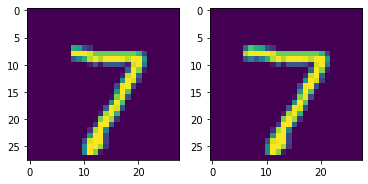

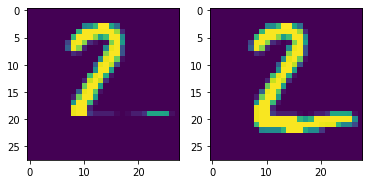

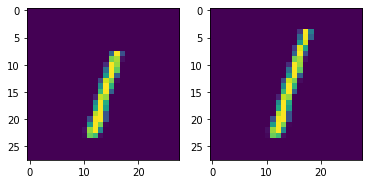

In [17]:
for n in range(3):
    an = ideal_action_N[n]
    yn = test_Dy[n].copy()
    xn = test_Dx[n]
    y = yn.copy()
    for a in an:
        y = ACTIONS_IRREV[a](y)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(y)
    axes[1].imshow(xn)
    plt.show()

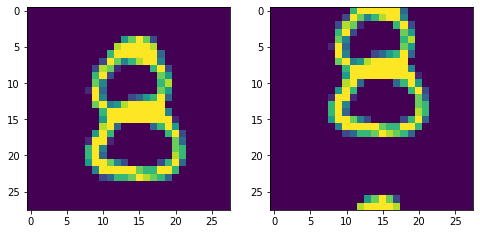

In [14]:
# img1
TYPE = 'udlr6_invert'
dataset = np.load('data/%s/train_dataset.npz' % TYPE)
Dx = dataset['original_dataset']
Dy = dataset['train_dataset']
labels = dataset['train_func_labels']
y = Dy[labels == 1][7]
x = Dx[labels == 1][7]
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(x)
axes[1].imshow(y)
plt.show()

In [7]:
# uで作ったデータはほんまにACTIONSの1が良い復元になるのか
dataset = np.load('data/%s/train_dataset.npz' % TYPE)
idx = dataset['train_func_labels']
TYPE = 'udlr2'
TYPE_LIST = list('udlr')
print({TYPE_LIST.index(k) for k in re.sub('\d', '', TYPE)} == set(idx))

True


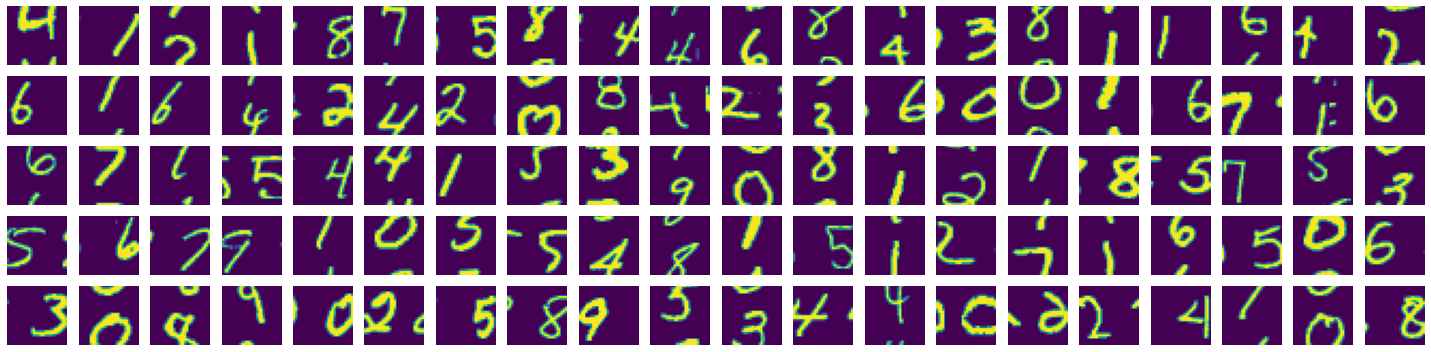

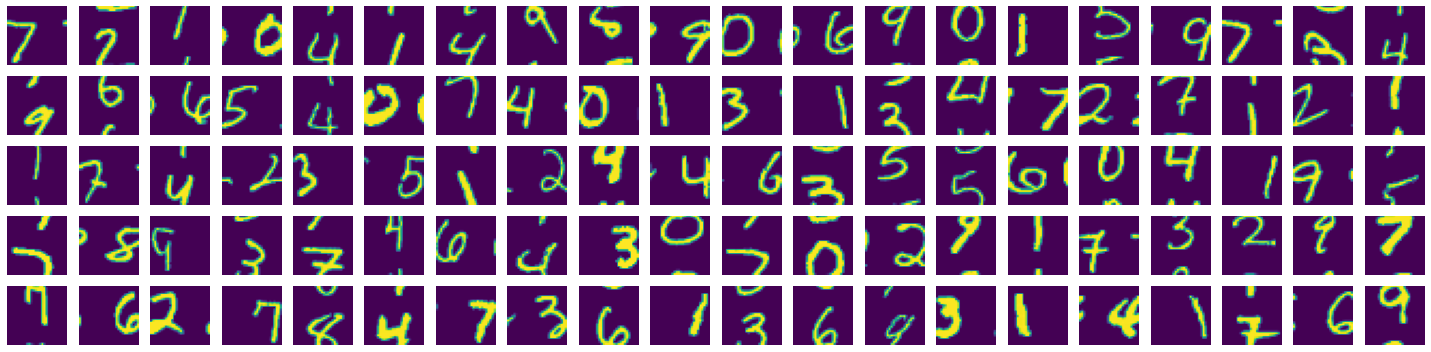

In [5]:
# できたデータを見てみる
train_data = np.load('data/%s/train_dataset.npz' % TYPE)['train_dataset']
fig, axes = plt.subplots(5, 20, figsize=(20, 5))
for i in range(5):
    for j in range(20):
        img = train_data[20 * i + j]
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
print()
plt.tight_layout()
plt.show()

test_data = np.load('data/%s/test_dataset.npz' % TYPE)['test_dataset']
fig, axes = plt.subplots(5, 20, figsize=(20, 5))
for i in range(5):
    for j in range(20):
        img = test_data[20 * i + j]
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()
print()

### 対角シフトのデータセット

In [7]:
def create_train_dataset(func_indices, shift_len, C=3, fname='', seed=SEED, size=SAMPLE_SIZE):
    funcs = [get_funcs(*delta) for delta in [
        (shift_len, shift_len),
        (shift_len, -shift_len),
        (-shift_len, shift_len),
        (-shift_len, -shift_len),
    ]]

    np.random.seed(seed)
    train_dataset = datasets.MNIST(root='../open_data/', train=True, download=True)
    idx = np.random.choice(train_dataset.data.shape[0], size)
    imgs = train_dataset.data[idx].numpy()
#     augumented_dataset = augument_data(imgs)
    originals = imgs
    originals = originals / 255

    train_filter_set = np.random.choice(func_indices, (originals.shape[0], C))
    train_dataset = apply(originals, train_filter_set, funcs)

    np.savez(
        os.path.join('data', fname),
        train_dataset=train_dataset,
        train_func_labels=train_filter_set,
        original_dataset=originals,
    )

In [8]:
# テストデータ
def create_test_dataset(shift_len, func_indices, fname=''):
    funcs = [get_funcs(*delta) for delta in [
        (shift_len, shift_len),
        (shift_len, -shift_len),
        (-shift_len, shift_len),
        (-shift_len, -shift_len),
    ]]
    
    np.random.seed(SEED + 1000)
    originals = datasets.MNIST(root='../open_data/', train=False, download=True).data.numpy()
    originals = originals / 255    
    test_filter_set = np.random.choice(func_indices, (originals.shape[0], 3))
    
    test_dataset = apply(originals, test_filter_set, funcs)
    np.savez(
        os.path.join('data', fname),
        test_dataset=test_dataset,
        original_dataset=originals,
        test_func_labels=test_filter_set,
    )

In [9]:
def create_diag_shift_dataset(shift_len):
    os.makedirs('data/shift%d' % shift_len, exist_ok=True)
    create_test_dataset(shift_len=shift_len, func_indices=[0], fname='shift%d/test_0_dataset.npz' % shift_len)
    create_test_dataset(shift_len=shift_len, func_indices=[0, 3], fname='shift%d/test_03_dataset.npz' % shift_len)
    create_test_dataset(shift_len=shift_len, func_indices=[1], fname='shift%d/test_1_dataset.npz' % shift_len)

    # f: forward, b: backward
    create_train_dataset(func_indices=[0], shift_len=shift_len, fname='shift%d/diag_xfyf_dataset.npz' % shift_len)
    create_train_dataset(func_indices=[0, 3], shift_len=shift_len, fname='shift%d/diag_xfyf_xbyb_dataset.npz' % shift_len)

### 1. シフト1のデータセットを作成する

In [10]:
create_diag_shift_dataset(shift_len=1)

### 2. シフト2のデータセットを作成する

In [11]:
create_diag_shift_dataset(shift_len=2)

### 2. シフト3のデータセットを作成する

In [12]:
create_diag_shift_dataset(shift_len=3)